# Linear Models

In [2]:
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get Data

In [3]:
def get_subject_from_path(path):
    normalized_path = os.path.normpath(path)
    path_components = normalized_path.split(os.sep)
    return path_components[-2][4:]

In [4]:
# Search for all functional connectivity files and read them into a
# numpy array.
fc_path = '/imaging3/owenlab/bpho/python_power_fc'
fc_paths = glob.glob(fc_path + '/**/power_fc.npy', recursive=True)

fcs = {}
for path in fc_paths:
    subject_id = get_subject_from_path(path)
    # print(subject_id)
    subject_fc = np.load(path)
    fcs[subject_id] = subject_fc[np.triu_indices(264, k=1)]
print("Number of functional connectivities:", len(fcs))

Number of functional connectivities: 722


In [5]:
print("Number of features (connections):", fcs["NDARAP912JK3"].shape[0])

Number of features (connections): 34716


## Get Labels

In [ ]:
wisc_label_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects with WISC.csv"
wisc_labels = pd.read_csv(wisc_label_path)
wisc_labels.set_index(keys='assessment WISC,EID', inplace=True)
# display(wisc_labels)

In [7]:
label_subject_ids = wisc_labels.index
subject_ages = wisc_labels["assessment Basic_Demos,Age"].to_numpy()
subjects_with_wisc = {}

for subject_id in label_subject_ids:
    if subject_id not in fcs:
        continue
    
    subject_wisc_fsiq_sum = wisc_labels.at[subject_id, 'assessment WISC,WISC_FSIQ_Sum']
    subjects_with_wisc[subject_id] = (fcs[subject_id], subject_wisc_fsiq_sum)

print(subjects_with_wisc['NDARAC331VEH'])

(array([ 0.58186466, -0.05859981,  0.08431777, ...,  0.39561737,
        0.3742862 ,  0.6218255 ], dtype=float32), 89)


In [8]:
fc_matrices = []
wisc_measure = []

for features in subjects_with_wisc.values():
    fc_matrices.append(features[0])
    wisc_measure.append(features[1])

X = np.array(fc_matrices)
y = np.array(wisc_measure)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (425, 34716) y shape: (425,)


## Dimensionality Reduction
I'm following the guide here: <https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html>.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [13]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X, y)

pls = PLSRegression(n_components=1)
pls.fit(X, y)

PLSRegression(n_components=1)

In [14]:
pca = pcr.named_steps['pca']
X_pca = pca.transform(X)

print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))
print(pca.components_.shape)
print(X_pca.shape)

X_pls = pls.transform(X)
print(X_pls.shape)

[0.21051498] 0.21051498
(1, 34716)
(425, 1)
(425, 1)


In [15]:
reg = pcr.named_steps['linearregression']
y_pcr_pred = reg.predict(X_pca)
y_pls_pred = pls.predict(X)

print("PCR Coef:", reg.coef_)
print("PCR r^2:", reg.score(X_pca, y))
print("PLS r^2:", pls.score(X, y))

PCR Coef: [-0.01682519]
PCR r^2: 0.0017985146684365017
PLS r^2: 0.0576099785179951


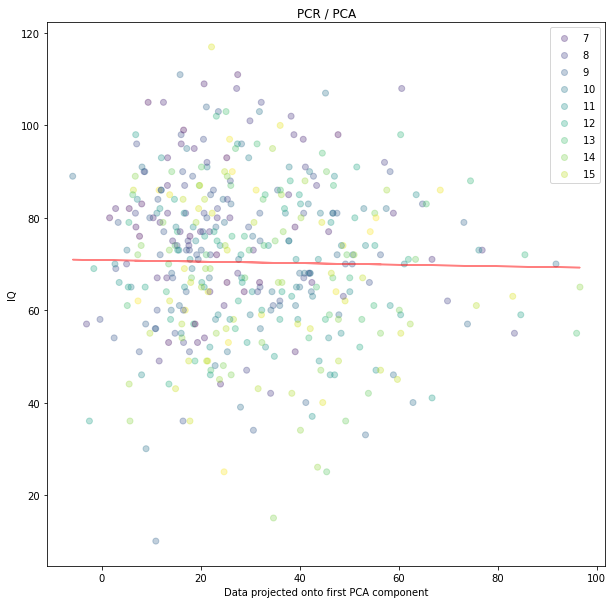

In [17]:
plt.figure(1, figsize=(10, 10))
scatter = plt.scatter(X_pca, y, c=subject_ages, alpha=0.3, label='Ground Truth')
plt.plot(X_pca, y_pcr_pred, alpha=0.5, color='red', label="Predictions")
plt.title("PCR / PCA")
plt.xlabel('Data projected onto first PCA component')
plt.ylabel('IQ')
plt.legend(*scatter.legend_elements())
plt.show()

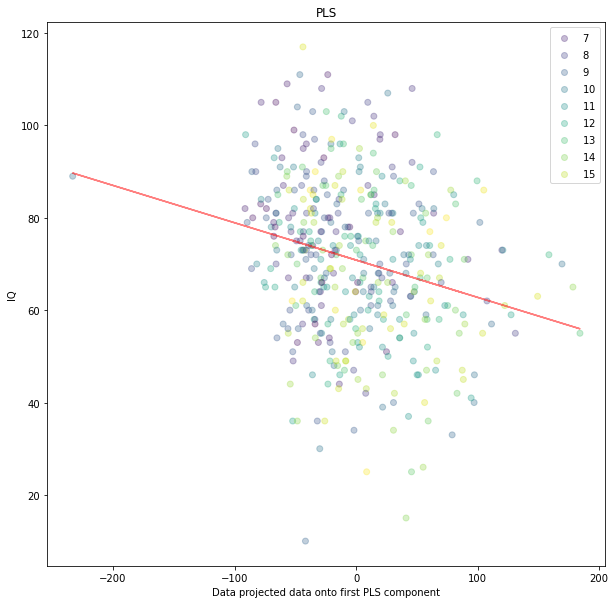

In [18]:
plt.figure(1, figsize=(10, 10))
plt.scatter(X_pls, y, c=subject_ages, alpha=0.3, label='Ground Truth')
plt.plot(X_pls, y_pls_pred, alpha=0.5, color='red', label="Predictions")
plt.title("PLS")
plt.xlabel('Data projected data onto first PLS component')
plt.ylabel('IQ')
plt.legend(*scatter.legend_elements())
plt.show()

## Feature Selection

In [17]:
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, chi2, mutual_info_regression)

In [30]:
var_thres = VarianceThreshold(threshold=0.12)
X_var_thres = var_thres.fit_transform(X)

print(X_var_thres.shape)

(425, 1)


In [21]:
reg = LinearRegression().fit(X_var_thres, y)
y_var_thres = reg.predict(X_var_thres)

print("LR w/ Variance Threshold:", reg.score(X_var_thres, y))

LR w/ Variance Threshold: 0.006174108434912173


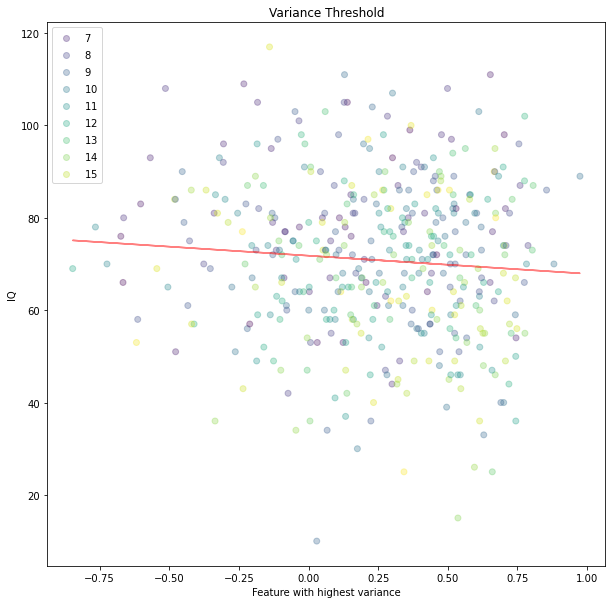

In [27]:
plt.figure(1, figsize=(10, 10))
scatter = plt.scatter(X_var_thres, y, c=subject_ages, alpha=0.3, label='Ground Truth')
plt.plot(X_var_thres, y_var_thres, alpha=0.5, color='red', label="Predictions")
plt.title("Variance Threshold")
plt.xlabel('Feature with highest variance')
plt.ylabel('IQ')
plt.legend(*scatter.legend_elements())
plt.show()

In [24]:
X_mutual_info = SelectKBest(
    mutual_info_regression, k=1).fit_transform(X, y)

print(X_mutual_info.shape)

(425, 1)


In [25]:
reg = LinearRegression().fit(X_mutual_info, y)
y_mutual_info = reg.predict(X_mutual_info)

print("LR w/ Mutual Information:", reg.score(X_mutual_info, y))

LR w/ Mutual Information: 0.0001848974192193431


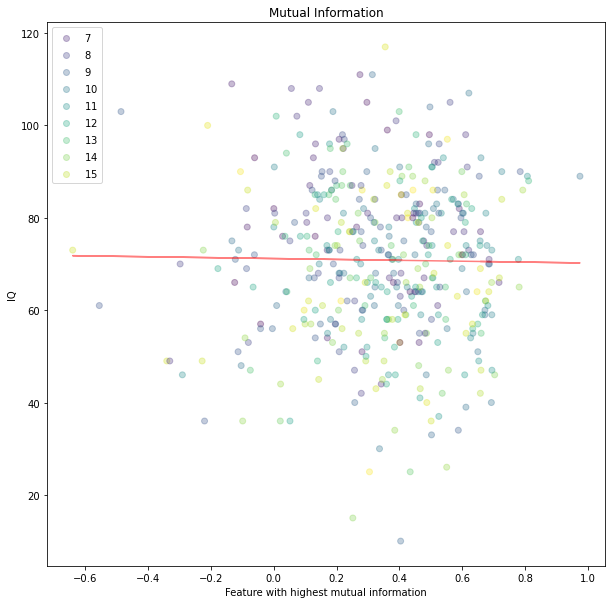

In [28]:
plt.figure(1, figsize=(10, 10))
scatter = plt.scatter(X_mutual_info, y, c=subject_ages, alpha=0.3, label='Ground Truth')
plt.plot(X_mutual_info, y_mutual_info, alpha=0.5, color='red', label="Predictions")
plt.title("Mutual Information")
plt.xlabel('Feature with highest mutual information')
plt.ylabel('IQ') 
plt.legend(*scatter.legend_elements())
plt.show()